In [6]:
import os
import cv2
from tqdm import tqdm
from imutils import paths
DST_FOLDER = "./GM-Closed/GM-Closed-Approve/"

In [7]:
WINDOW_NAME = "annotation"
ANN_FILE = "ann.txt"
images_path = list(paths.list_images(DST_FOLDER))

In [24]:
class Annotator:
    def __init__(self, window_name, ann_file_path):
        self._window_name = window_name
        self._ann_file_path = ann_file_path
        self._current_fname = ""
        self._done = False
        self.x = 0
        def opencv_callback(event, x, y, *args):

            if event == cv2.EVENT_LBUTTONDOWN:
                with open(self._ann_file_path, "a") as ann_file:
                    for c in range(3):
                        if x == 2:
                            ann_file.write(f"{x},{y},parafuso3\n")
                            self._done = True
                            x = 0
                        elif x == 1:
                            ann_file.write(f"{x},{y},parafuso2,")
                            x += 1
                        else:
                            ann_file.write(f"{self._current_fname},{x},{y},parafuso1,")
                            x += 1
                        print("FOI")

            elif event == cv2.EVENT_MOUSEMOVE:
                image_guide_lines = image.copy()
                cv2.line(image_guide_lines, (0, y), (image_guide_lines.shape[1] - 1, y), (0, 255, 0))
                cv2.line(image_guide_lines, (x, 0), (x, image_guide_lines.shape[0] - 1), (0, 255, 0))
                cv2.imshow(self._window_name, image_guide_lines)
        cv2.namedWindow(WINDOW_NAME)
        cv2.setMouseCallback(WINDOW_NAME, opencv_callback)
    
    @property
    def done(self):
        if self._done:
            self._done = False
            return True
        else:
            return False
    
    @property
    def current_fname(self):
        return self._current_fname
    
    @current_fname.setter
    def current_fname(self, value):
        assert isinstance(value, str), "current_fname must be a string."
        self._current_fname = value
annotator = Annotator(WINDOW_NAME, ANN_FILE)
for fname in tqdm(images_path):
    image = cv2.imread(fname)
    annotator.current_fname = fname
    cv2.imshow(WINDOW_NAME, image)
    while not annotator.done:
        cv2.waitKey(1)
cv2.destroyAllWindows()

  0%|          | 0/612 [00:00<?, ?it/s]

FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI
FOI


  0%|          | 0/612 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [10]:
import random
basename, ext = os.path.splitext(ANN_FILE)
train_file = f"{basename}_train{ext}"
val_file = f"{basename}_val{ext}"
with open(ANN_FILE) as all_ann, open(train_file, "w") as train_ann, open(val_file, "w") as val_ann:
    lines = [line for line in all_ann]
    random.shuffle(lines)
    for line in lines:
        if random.randint(0, 10) < 8:
            train_ann.write(line)
        else:
            val_ann.write(line)  

In [11]:
from tensorflow.keras.utils import Sequence
from imgaug import augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = [112, 112]

In [17]:
class BatchGenerator(Sequence):
    def __init__(self, csv_path, size=(224, 224), shuffle=True, norm=None, jitter=True, batch_size=8):
        
        self._shuffle = shuffle
        self._batch_size = batch_size
        self._size = size
        self._norm = norm
        self._jitter = jitter
        with open(csv_path) as ann_file:
            lines = [line for line in ann_file]
        
        self._data = []
        for line in tqdm(lines):
            fname, x, y, x1, y1, x2, y2, label = line.strip().split(",")
            image = cv2.imread(fname)
            x = int(x) / image.shape[1]
            y = int(y) / image.shape[0]
            x = int(x1) / image.shape[1]
            y = int(y1) / image.shape[0]
            x = int(x2) / image.shape[1]
            y = int(y2) / image.shape[0]
            image = cv2.resize(image, tuple(size))
            info = {"image": image, "x": x, "y": y,"x1": x1, "y1": y1,"x2": x2, "y2": y2, "label": label, "fname": fname}
            self._data.append(info)
            
        sometimes = lambda aug: iaa.Sometimes(0.5, aug)

        self._aug_pipe = iaa.Sequential(
            [

                iaa.Fliplr(0.5),  # horizontally flip 50% of all images
                iaa.Flipud(0.2),  # vertically flip 20% of all images
                sometimes(iaa.Affine(
                    scale={"x": (0.8, 1.2), "y": (0.8, 1.2),"x": (0.8, 1.2), "y": (0.8, 1.2),"x": (0.8, 1.2), "y": (0.8, 1.2)},  # scale images to 80-120% of their size, per axis
                    translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent
                    rotate=(-50, 50),  # rotate by -45 to +45 degrees
                    shear=(-5, 5),  # shear by -16 to +16 degrees
                )),
                iaa.SomeOf((0, 5),
                           [
                               iaa.OneOf([
                                   iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                                   iaa.AverageBlur(k=(2, 7)),
                                   # blur image using local means (kernel sizes between 2 and 7)
                                   iaa.MedianBlur(k=(3, 11)),
                                   # blur image using local medians (kernel sizes between 2 and 7)
                               ]),
                               iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                               iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                               iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                               # add gaussian noise
                               iaa.OneOf([
                                   iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                                   iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                               ]),
                               iaa.Invert(0.05, per_channel=True),  # invert color channels
                               iaa.Add((-10, 10), per_channel=0.5),  # change brightness of images
                               iaa.Multiply((0.5, 1.5), per_channel=0.5),  # change brightness of images
                               iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                           ],
                           random_order=True
                           )
            ],
            random_order=True
        )
            
    def __len__(self):
        return int(np.ceil(len(self._data) / self._batch_size))
    
    def __getitem__(self, idx):
        l_bound = idx * self._batch_size
        r_bound = (idx + 1) * self._batch_size

        if r_bound > len(self._data):
            r_bound = len(self._data)
            l_bound = r_bound - self._batch_size

        instance_count = 0
        x_batch = np.zeros((r_bound - l_bound, self._size[1], self._size[0], 3))
        y_batch = np.zeros((r_bound - l_bound, 2))

        for instance_count, train_instance in enumerate(self._data[l_bound:r_bound]):
            # augment input image and fix object's position and size
            image = train_instance["image"]
            image, [x, y] = self.aug_image(train_instance)
            if self._norm is not None:
                image = self._norm(image)
            x_batch[instance_count] = image
            y_batch[instance_count, 0] = x
            y_batch[instance_count, 1] = y

        return x_batch, y_batch

    def on_epoch_end(self):
        if self._shuffle:
            np.random.shuffle(self._data)
            
    def aug_image(self, train_instance):
        image = train_instance['image'].copy()

        h = image.shape[0]
        w = image.shape[1]

        x = int(train_instance['x'] * w)
        y = int(train_instance['y'] * h)

        keypoints = KeypointsOnImage([Keypoint(x=x, y=y)], shape=image.shape)

        if self._jitter:
            image, keypoints = self._aug_pipe(image=image, keypoints=keypoints)

        x = keypoints.keypoints[0].x
        y = keypoints.keypoints[0].y
        x = x / w
        y = y / w
        
        return image, [x, y]

In [18]:
_norm = lambda x: x / 255
train_generator = BatchGenerator(train_file, norm=_norm, batch_size=12, size=IMG_SIZE)
val_generator = BatchGenerator(val_file, norm=_norm, batch_size=3, shuffle=False, jitter=False, size=IMG_SIZE)

100%|██████████| 1310/1310 [00:10<00:00, 130.71it/s]
c:\Users\nia1ct\Desktop\repositorio\TreinamentoVisaoComputacional\.venv\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)
100%|██████████| 529/529 [00:03<00:00, 144.22it/s]


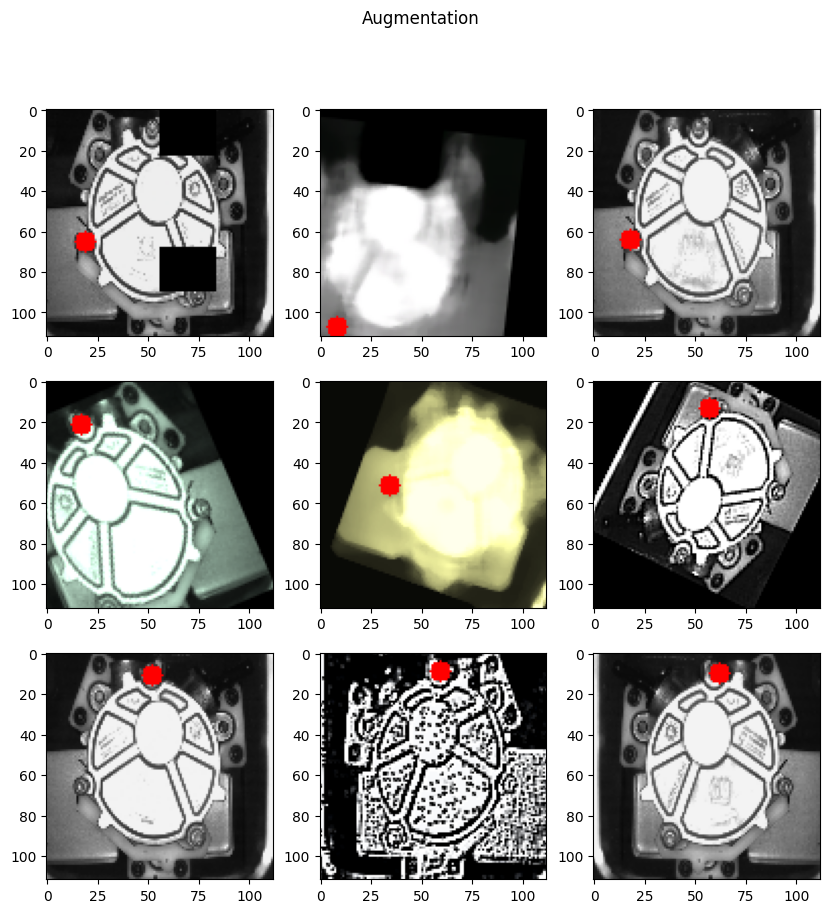

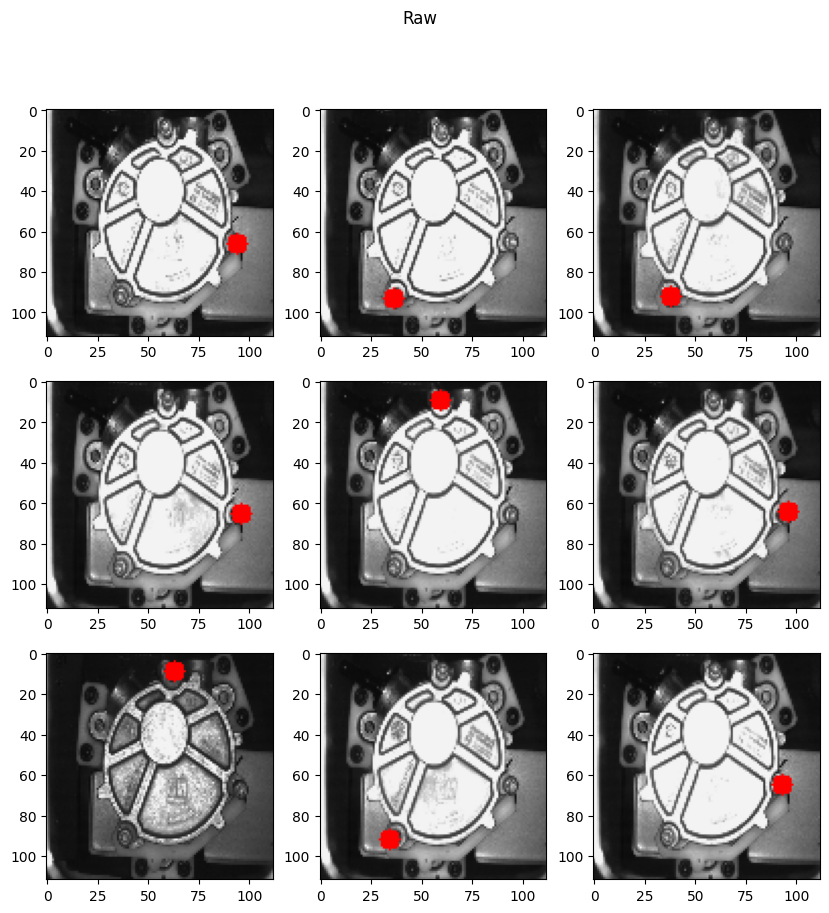

In [19]:
plt.figure(figsize=(10,10))
for i, (batch_x, batch_y) in enumerate(train_generator):
    if i == 9:
        break
    plt.subplot(3,3,i+1)
    debug_img = np.uint8(batch_x[0] * 255)
    debug_coord = batch_y[0]
    debug_coord[0] = debug_coord[0] * debug_img.shape[1]
    debug_coord[1] = debug_coord[1] * debug_img.shape[0]
    debug_coord = debug_coord.astype(np.int32)
    cv2.circle(debug_img, tuple(debug_coord), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.suptitle('Augmentation')
plt.show()

plt.figure(figsize=(10,10))
for i, (batch_x, batch_y) in enumerate(val_generator):
    if i == 9:
        break
    plt.subplot(3,3,i+1)
    debug_img = np.uint8(batch_x[0] * 255)
    debug_coord = batch_y[0]
    debug_coord[0] = debug_coord[0] * debug_img.shape[1]
    debug_coord[1] = debug_coord[1] * debug_img.shape[0]
    debug_coord = debug_coord.astype(np.int32)
    cv2.circle(debug_img, tuple(debug_coord), 5, (0, 0, 255), -1)
    plt.imshow(cv2.cvtColor(debug_img, cv2.COLOR_BGR2RGB))
plt.suptitle('Raw')
plt.show()